In [24]:
import sys
import os

sys.path.append(os.path.join(os.getcwd(), ".."))

import torch
import datasets
from tqdm import tqdm
import numpy as np
from torch.nn.functional import softmax
from torch.utils.data import DataLoader
from datasets import DatasetDict
from transformers import AutoTokenizer, DataCollatorWithPadding
from src.models.hf_model import SequenceClassificationTransformer
from matplotlib.animation import FuncAnimation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.lines as lines
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.patches as patches

In [2]:
# datasets
mnli = datasets.load_dataset("glue", "mnli")
hans = datasets.load_dataset("hans")

Reusing dataset glue (/home/meissner/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad)


  0%|          | 0/5 [00:00<?, ?it/s]

Reusing dataset hans (/home/meissner/.cache/huggingface/datasets/hans/plain_text/1.0.0/1bbcb735c482acd54f2e118074b59cfd2bf5f7a5a285d4d540d1e632216672ac)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
def get_dataloader(dataset, tokenizer, max_length=128, batch_size=256):
    def preprocess_func(examples: dict):
        args = (examples["premise"], examples["hypothesis"])
        result = tokenizer(*args, max_length=max_length, truncation=True)
        return result
    dataset = dataset.map(preprocess_func, batched=True, num_proc=4)
    if "label" in dataset.column_names:
        dataset = dataset.rename_column("label", "labels")
    dataset.set_format(
        "torch",
        columns=[
            "input_ids",
            "attention_mask",
            "token_type_ids",
            "labels",
        ],
    )
    dataloader = DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=DataCollatorWithPadding(tokenizer=tokenizer)
    )
    return dataloader

In [4]:
def get_preds(model_path, dataset):
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model = SequenceClassificationTransformer.load_from_checkpoint(model_path)
    model.eval()
    model.to(device)
    tokenizer = AutoTokenizer.from_pretrained(model.hparams.huggingface_model)
    dataloader = get_dataloader(dataset, tokenizer)
    predictions = []
    for idx, batch in enumerate(tqdm(dataloader)):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            logits, preds = model(batch)
            soft_preds = softmax(logits, dim=1).detach().cpu().tolist()
            predictions.extend(soft_preds)
    return np.array(predictions)

In [5]:
weak_2k5e_000 = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/weak/bert/mnli/2K-5epoch/000/multiruns/2022-03-09/14-07-32/0/checkpoints/last.ckpt"
baseline = "/remote/csifs1/disk0/meissner/shortcut-pruning-old/bert_mnli_seeds/seed_111/checkpoints/last.ckpt"
# debias = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/debiasing/bert/mnli/multiruns/2022-01-17/23-02-37/0/last.ckpt"
debias = "/remote/csifs1/disk0/meissner/shortcut-pruning/experiments/debiasing/bert/mnli/utama/runs/2022-03-07/11-12-22/checkpoints/last.ckpt"

In [6]:
!ls /remote/csifs1/disk0/meissner/shortcut-pruning/experiments/debiasing/bert/mnli/multiruns/2022-01-17/23-02-37/0

config_tree.log  last.ckpt  train.log  wandb


In [7]:
hans = datasets.load_dataset("hans")
hans_entail = hans["validation"].filter(lambda example: example['label'] == 0)
hans_nonentail = hans["validation"].filter(lambda example: example['label'] == 1)

Reusing dataset hans (/home/meissner/.cache/huggingface/datasets/hans/plain_text/1.0.0/1bbcb735c482acd54f2e118074b59cfd2bf5f7a5a285d4d540d1e632216672ac)


  0%|          | 0/2 [00:00<?, ?it/s]

Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/hans/plain_text/1.0.0/1bbcb735c482acd54f2e118074b59cfd2bf5f7a5a285d4d540d1e632216672ac/cache-9104922d72deda17.arrow
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/hans/plain_text/1.0.0/1bbcb735c482acd54f2e118074b59cfd2bf5f7a5a285d4d540d1e632216672ac/cache-ec50af6743c7ddcf.arrow


In [8]:
print(len(hans['validation']))
print(len(hans_entail))
print(len(hans_nonentail))

30000
15000
15000


In [9]:
preds_baseline = get_preds(baseline, hans_nonentail)
preds_debiased = get_preds(debias, hans_nonentail)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Loading cached processed dataset at /home/meissner/.cache/huggingface/datasets/hans/plain_text/1.0.0/1bbcb735c482acd54f2e118074b59cfd2bf5f7a5a285d4d540d1e6

In [17]:
def interpolate(start_points, end_points, i, max=1000):
        return start_points * (max-i)/max + end_points * i/max

In [21]:
def project_points(points):
    # Convert points one at a time
    tripts = np.zeros((points.shape[0],2))
    for idx in range(points.shape[0]):
        # Init to triangle centroid
        x = 1.0 / 2
        y = 1.0 / (2 * np.sqrt(3))
        # Vector 1 - bisect out of lower left vertex 
        p1 = points[idx, 0]
        x = x - (1.0 / np.sqrt(3)) * p1 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p1 * np.sin(np.pi / 6)
        # Vector 2 - bisect out of lower right vertex  
        p2 = points[idx, 1]  
        x = x + (1.0 / np.sqrt(3)) * p2 * np.cos(np.pi / 6)
        y = y - (1.0 / np.sqrt(3)) * p2 * np.sin(np.pi / 6)        
        # Vector 3 - bisect out of top vertex
        p3 = points[idx, 2]
        y = y + (1.0 / np.sqrt(3) * p3)
        tripts[idx,:] = (x,y)
    return tripts

In [25]:
def animate_points(start_points, end_points):
    fig = plt.figure(figsize=(7,7))
    l1 = lines.Line2D([0, 0.5, 1.0, 0], [0, np.sqrt(3) / 2, 0, 0], color="k")  # xcoords  # ycoords
    fig.gca().add_line(l1)
    fig.gca().xaxis.set_major_locator(ticker.NullLocator())
    fig.gca().yaxis.set_major_locator(ticker.NullLocator())
    fig.gca().text(-0.05, -0.05, "ent")
    fig.gca().text(1.05, -0.05, "neut")
    fig.gca().text(0.5, np.sqrt(3) / 2 + 0.05, "cont")
    fig.gca().set_xlim(-0.2, 1.2)
    fig.gca().set_ylim(-0.2, 1.2)
    projected = project_points(start_points)
    scatter = plt.scatter(projected[:,0], projected[:,1], s=1)
    def update(i):
        points = interpolate(start_points, end_points, i, max=300)
        projected = project_points(points)
        scatter.set_offsets(projected)
        return scatter,
    anim = FuncAnimation(fig, update, frames=range(100), interval=20)
    return anim

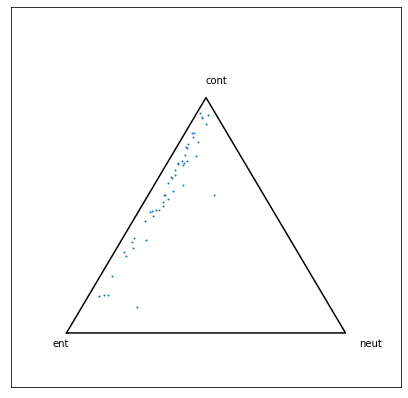

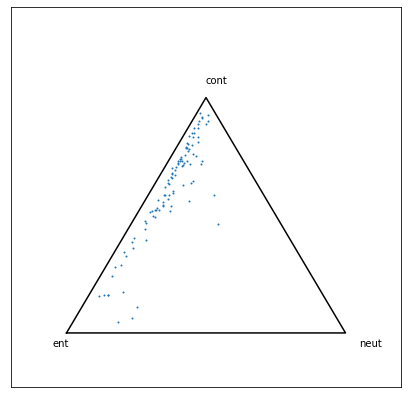

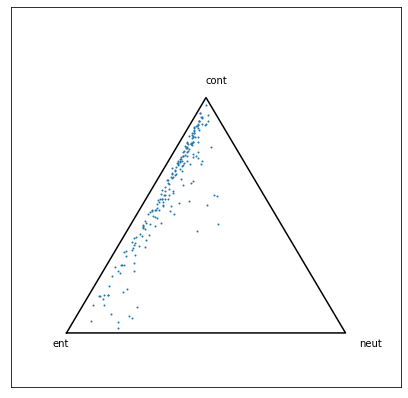

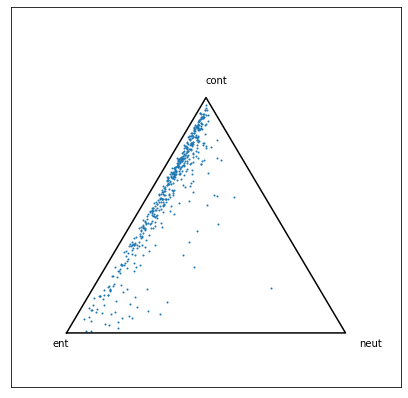

In [27]:
animate_points(preds_baseline[:50], preds_debiased[:50]).save("hans_nonentail_50.mp4")
animate_points(preds_baseline[:100], preds_debiased[:100]).save("hans_nonentail_100.mp4")
animate_points(preds_baseline[:200], preds_debiased[:200]).save("hans_nonentail_200.mp4")
animate_points(preds_baseline[:500], preds_debiased[:500]).save("hans_nonentail_500.mp4")